## Pandana and osmnx

The [pandana](https://udst.github.io/pandana) library is used for calculating distances to points of interest (POIs) for every node in a map.  This can be used to create accessibility maps and other nearest points calculations. 

This notebook explores the use of pandana guided in part by these sources:

- [pandana tutorial](https://udst.github.io/pandana/tutorial.html) Pretty basic, doesn't explain very clearly.
- [Geoff Boeing](https://github.com/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-simple.ipynb) a couple notebooks from his nice urban data science course.
- [Blog post on pedestrian accessibility](https://towardsdatascience.com/measuring-pedestrian-accessibility-97900f9e4d56

In [1]:
import numpy as np
import random
from pandana.loaders import osm
import geopandas as gpd
from shapely.geometry import box, LineString, Point,MultiPoint
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

I'll pull in a familiar neighborhood in Queens:

In [2]:
place_name = 'Washington, DC'
G = ox.graph_from_place(place_name)

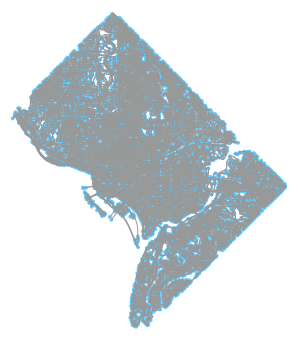

In [3]:
ox.plot_graph(G);

I want to find the bounding box for this street network.  There may be more direct ways, but this is how I can do it:

In [4]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
west, south, east, north  = gdf_nodes.unary_union.bounds

In [5]:
south, west, north, east

(38.8098831, -77.1173348, 38.994505, -76.9105245)

#### load osm network into pandana

Using the pandana.osm loader

In [6]:
net = osm.pdna_network_from_bbox(south, west, north,east)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](38.80988310,-77.11733480,38.99450500,-76.91052450);>;);out;'}"
Downloaded 50,490.5KB from www.overpass-api.de in 10.53 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 19.13 seconds
Returning OSM data with 331,676 nodes and 67,912 ways...
Edge node pairs completed. Took 90.08 seconds
Returning processed graph with 94,090 nodes and 138,848 edges...
Completed OSM data download and Pandana node and edge table creation in 114.13 seconds


In [7]:
net.impedance_names

['distance']

Supposedly pre-computing over a given horizon distance will save on later queries.

In [8]:
net.precompute(2000)

Somewhat confusingly the `.bbox` method returns bounding box (though curiously as [longmin, latmin, longmax, latmax] which is different from [latmin,longmin, latmax, longmax] way the network is loaded from osm)

In [9]:
net.bbox

[-77.1213605, 38.806376, -76.905285, 38.9971914]

Note that at the edges and nodes can be displayed as pandas dataframes

In [10]:
net.edges_df.head()

from          to   distance
234661 1222437943  234661  1222437943  17.580063
       1222438089  234661  1222438089  64.599788
275232 275239      275232      275239  66.846886
       1222438117  275232  1222438117  40.564993
       1222438217  275232  1222438217  76.396486

In [11]:
net.nodes_df.head()

,x,y
id,,
234661,-77.050635,38.840091
275232,-77.049989,38.837246
275233,-77.050125,38.834875
275234,-77.050040,38.833668
275235,-77.049943,38.833505


### Adding points of interest (POIs) to the pandana network

We add points of interest such as restaurants.  We could pull these in from actual data but we'll use ramdomly placed points here.  I got this code from someone (can't remember source now!)

In [26]:
poi_count = 500

# this function makes those POI into Shapely points

def make_n_pois(north, south, east, west, poi_count):
    for poi in range(poi_count):
        x = (east - west) * random.random() + west
        y = (north - south) * random.random() + south
        yield Point(x, y)
        
pois = list(make_n_pois(north, south, east, west, poi_count))

In [27]:
pois_gdf = gpd.GeoDataFrame(pois, columns=['geometry'])
x, y = pois_gdf.geometry.x, pois_gdf.geometry.y

We use the `.init_pois` and `.set_pois` methods. 

The following initializes the 'Restaurants' POIs.  We also let it know that (in later nearest_pois queries) pois will be at a max distance of 2000 meters and the query will be for a max of 10 nearest POIs.

Pandana then connects the pois to the closest node in the network (assuming no 'impedance' in that connecting distance). 

In [28]:
net.init_pois(num_categories=1, max_dist=2000, max_pois=10)
net.set_pois("restaurants", 2000, 10, x, y)

### Nearest POIs

The following `.nearest_pois` call will, for every node in the network calculate the distance to the 5 nearest POI.

This returns a dataframe with one row per node and 5 columns, each indicating the distance to the 1st, 2nd, ... poi (up to the maximum 1000 meters).

This will be useful in constructing accessibility maps (since now from every node we know proximity to each poi).

In [29]:
a = net.nearest_pois(1000, "restaurants", num_pois=5)
a.head()

,1,2,3,4,5
id,,,,,
234661,351.835999,1000.000000,1000.0,1000.0,1000.0
275232,675.713013,785.012024,1000.0,1000.0,1000.0
275233,612.133972,907.245972,1000.0,1000.0,1000.0
275234,478.901001,1000.000000,1000.0,1000.0,1000.0
275235,458.664001,1000.000000,1000.0,1000.0,1000.0


The average distance to a nearest restaurant from a node in the network is 126 feet, 216 feet to the second closest and so forth.

In [30]:
a.mean()

1    597.925324
2    822.856928
3    921.507078
4    969.432193
5    991.453866
dtype: float64

### Aggregation queries

We might want to know the answer to a question such as what is restaurant capacity within a 500 meter radius around a node.

(Or how many accident fatalities within a 300 meter radius of an intersection).

Let's add some (fake) data on restaurant capacity to our (fake) list of restaurants.


In [31]:
pois_gdf['capacity'] = np.random.randint(10,100, size=len(pois_gdf) )

We next match these to the nearest node_id and integrate this info to the network (in other words the 'capacity' information is now a characteristic of each node).

In [32]:
pois_gdf["node_ids"] = net.get_node_ids(x, y)

In [33]:
net.set(pois_gdf.node_ids, variable=pois_gdf.capacity, name="capacity")

In [34]:
pois_gdf.head(2)

,geometry,capacity,node_ids
0,POINT (-77.07659760141235 38.95289787552024),61,5445243133
1,POINT (-76.97157755739643 38.95889267654881),91,4443009937


Now we will aggregate to find (in this contrived example) the seating in a networked 1000 meter distance from each node.

In [35]:
s = net.aggregate(1000, type="sum", decay="linear", name="capacity")

### Plot computed values

The plot for this made up example isn't that interesting but identifies neighborhoods with more restaurant capacity.

(Note that pandana's output bounding box (from `net.bbox`) needs to be adjusted to plot via pandana!?)

In [36]:
west, south, east, north = net.bbox 
qbbox = [south, west, north, east]

C:\Users\jconning\AppData\Local\Continuum\anaconda3\lib\site-packages\pandana\network.py:458: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  bbox[1], bbox[0], bbox[3], bbox[2], ax=ax, **bmap_kwargs)


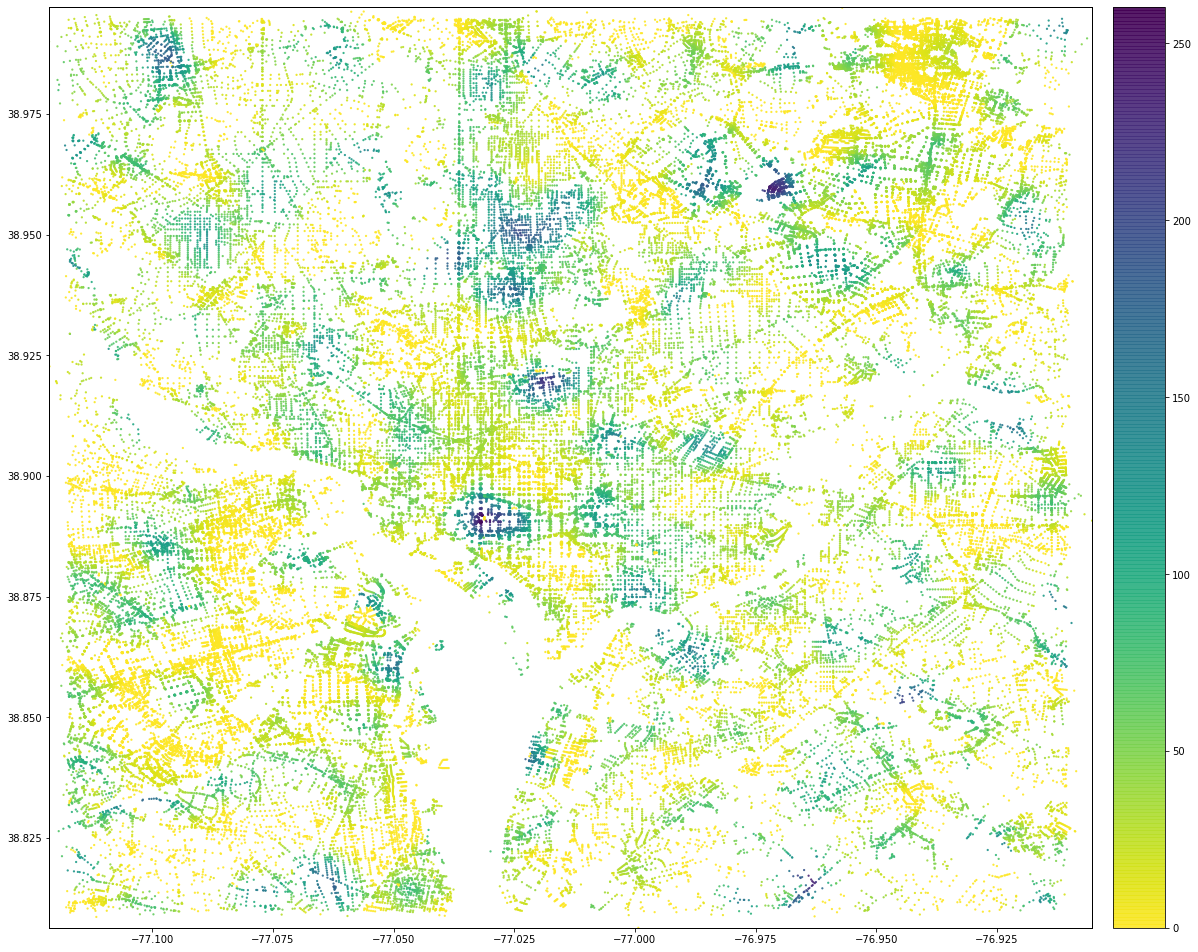

In [37]:
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

net.plot(s, bbox=qbbox,
         fig_kwargs={'figsize': [20, 20]},
              bmap_kwargs={'suppress_ticks': False,
                  'resolution': 'h'},
         plot_kwargs=plot_kwargs);